# Задание к Уроку 3. Евграфов Михаил. Б03-913С2

## Используемые библиотеки. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Константы.

In [2]:
pair_len = 13
sqr_len = 12.8
width = 6.4

phi_beg, phi_end = 0, 2 * np.pi
r_beg, r_end = 1.15, 5
x_shift, y_shift = -0.15, 0

N_trans, N_rad = 100, 145

u_inf = 1
c = 1

## Вспомогательные функции для расчётов.

In [3]:
def get_polar_grid(N_trans, N_rad, x_shift, y_shift,
                  r_beg, r_end, phi_beg, phi_end):
    
    phis = np.linspace(phi_beg, phi_end, N_rad)
    rs = np.linspace(r_beg, r_end, N_trans)
    
    PHIS, RS = np.meshgrid(phis, rs)
    
    X = RS * np.cos(PHIS) + x_shift
    Y = RS * np.sin(PHIS) + y_shift
    
    return X, Y

In [4]:
def calculate_transormation(z, c):
    
    return z + c ** 2 / z

In [5]:
def transform_grid(X, Y, c):
    
    Z = calculate_transormation(X + Y * 1j, c)
    
    return Z.real, Z.imag

In [6]:
def calculate_dipole_intensity(R, u_inf):
    
    return 2 * np.pi * u_inf * R ** 2

In [7]:
def calculate_stream_dipole(kappa, x0, y0, X, Y):
    
    psi = - kappa / 2 / np.pi * (Y - y0) / ((X - x0) ** 2 + (Y - y0) ** 2)
    
    return psi

In [8]:
def calculate_stream_velocity(_shape, u_inf, alpha):
    
    u = u_inf * np.ones(shape=_shape) * np.cos(alpha)
    v = u_inf * np.ones(shape=_shape) * np.sin(alpha)
    
    return u, v

In [9]:
def calculate_dipole_velocity(kappa, x0, y0, X, Y):
    
    U = kappa / 2 / np.pi * ((X - x0) ** 2 - (Y - y0) ** 2)
    V = kappa / 2 / np.pi * 2 * (X - x0) * (Y - y0)
    den = ((X - x0) ** 2 + (Y - y0) ** 2) ** 2
    
    return -U / den, -V / den

## Вспомогательные функции для отрисовки.

In [10]:
def paint_scatter(ax, _title, X, Y, _color='b', _grid=False):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.scatter(X, Y, s=1, marker='o', color=_color)
    
    x_shift = abs(X.min() - X.max()) / 8
    y_shift = abs(Y.min() - Y.max()) / 8
    
    ax.set_xlim(X.min() - x_shift, X.max() + x_shift)
    ax.set_ylim(Y.min() - y_shift, Y.max() + y_shift)
    
    ax.grid(_grid)

In [11]:
def paint_contour(ax, _title, X, Y, Z, _color='k'):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.contour(X, Y, Z, colors='k', linestyles='solid', levels=50)
    
    x_shift = abs(X.min() - X.max()) / 8
    y_shift = abs(Y.min() - Y.max()) / 8
    
    ax.set_xlim(X.min() - x_shift, X.max() + x_shift)
    ax.set_ylim(Y.min() - y_shift, Y.max() + y_shift)

In [12]:
def paint_quiver(ax, _title, X, Y, U, V,):
    
    ax.set_title(_title, fontsize=20, fontweight='bold')
    ax.set_xlabel('x', fontsize=15, fontweight='bold')
    ax.set_ylabel('y', fontsize=15, fontweight='bold')
    
    ax.quiver(X[::3], Y[::3], U[::3], V[::3], scale=50)
    
    shift = abs(X.min() - X.max()) / 2 / np.sqrt(2) * (np.sqrt(2) - 1)
    
    ax.set_xlim(X.min() + shift, X.max() - shift)
    ax.set_ylim(Y.min() + shift, Y.max() - shift)

## Пункт 2. Введение в преобразование Жуковского. 

### Подпункт 2.1:

$ R = 1.5 $

$ C = 1 $

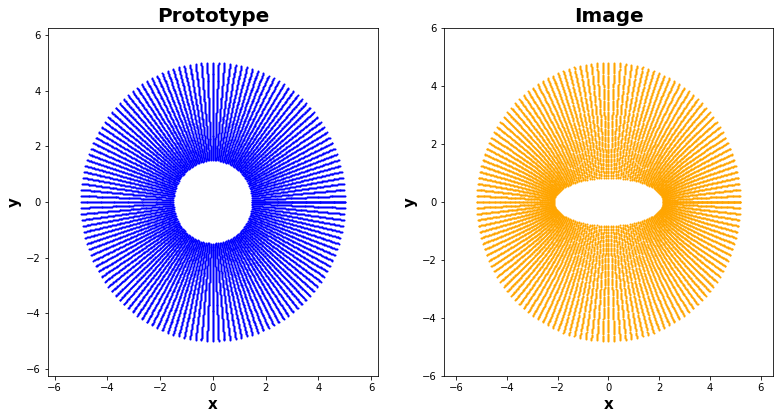

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, 0, 0, 
                        1.5, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в эллипс.

### Подпункт 2.2:

$ R = 1.2 $

$ C = 1 $

$ \Delta x_{c} = C - R $

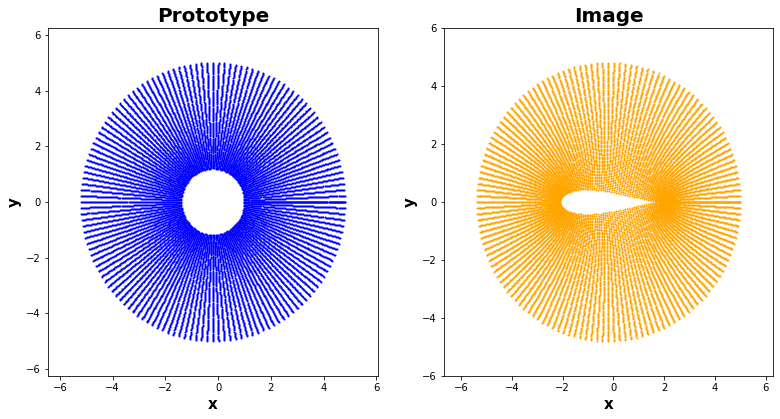

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, c - 1.2, 0, 
                        1.2, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в симметричный профиль.

### Подпункт 2.3:

$ R = \sqrt{(C - x_c)^2 + y_c^2} $

$ C = 1.5 $

$ \Delta x_{c} = -0.1 $

$ \Delta y_{c} = 0.1 $

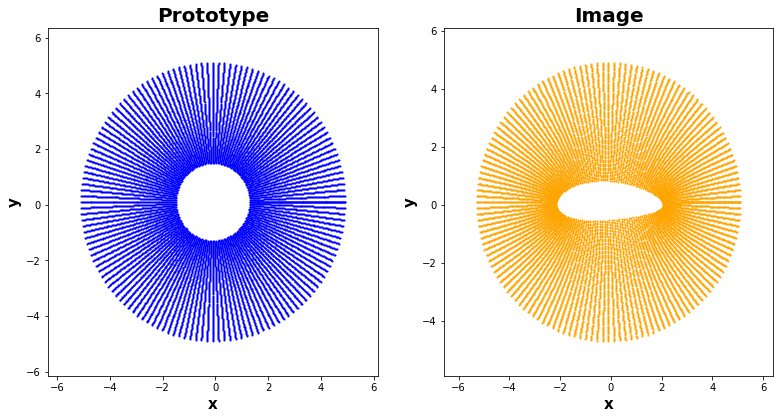

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

r = np.sqrt((1.5 - 0.1) ** 2 + 0.1 ** 2)

X0, Y0 = get_polar_grid(N_trans, N_rad, -0.1, 0.1, 
                        r, r_end, phi_beg, phi_end)
X1, X2 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0)
paint_scatter(axs[1], 'Image', X1, X2, _color='orange')

plt.show()

**Вывод**: При преобразовании Жуковского с данными параметрами окружность переходит в несимметричный профиль.

## Пункт 3. Получение расчётной сетки. 

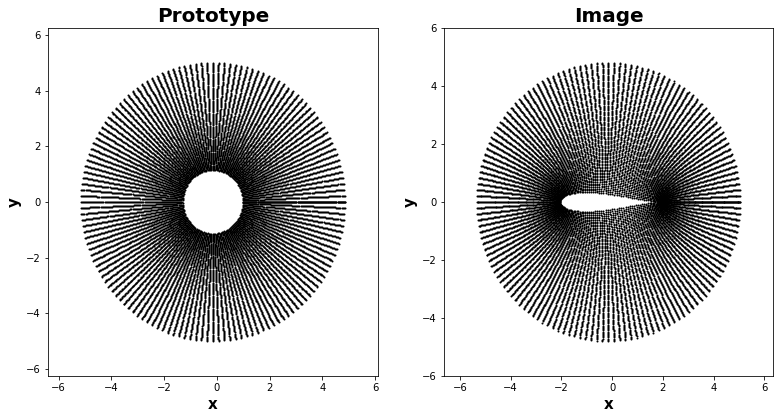

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

X0, Y0 = get_polar_grid(N_trans, N_rad, x_shift, y_shift,
                        r_beg, r_end, phi_beg, phi_end)
X1, Y1 = transform_grid(X0, Y0, c)

paint_scatter(axs[0], 'Prototype', X0, Y0, _color='k')
paint_scatter(axs[1], 'Image', X1, Y1, _color='k')

plt.show()

## Пункт 4. Обтекание симметричного профиля под нулевым углом атаки. 

### Подпункт 4.1. Функция тока. 

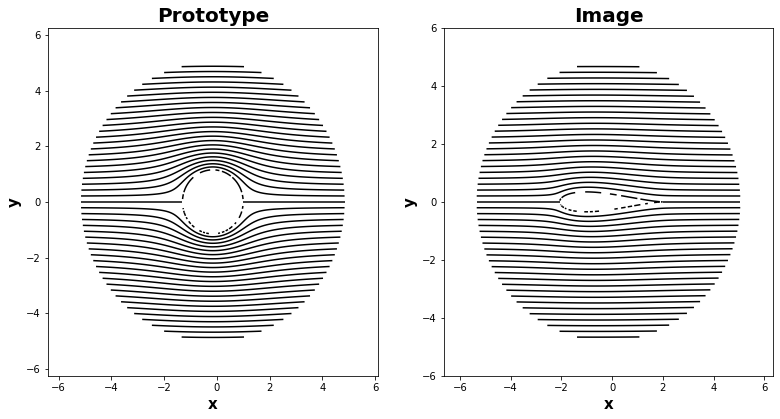

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(pair_len, width))

intensity = calculate_dipole_intensity(r_beg, u_inf)

psi_dipole0 = calculate_stream_dipole(intensity, x_shift, y_shift, X0, Y0)
psi_stream0 = u_inf * Y0
psi0 = psi_dipole0 + psi_stream0

paint_contour(axs[0], 'Prototype', X0, Y0, psi0)
paint_contour(axs[1], 'Image', X1, Y1, psi0)

### Подпункт 4.2. Линии тока. 